In [234]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
#from ridgeplot import ridgeplot
import joypy

Vom genera date x si y care sa respecte asumptiile, iar apoi alte exemple astfel incat un model liniar sa aiba incalcate diferite asumptii.


In [235]:
#generam datele de venit

n_observations = 100000

#normal distributed scenario
# mean_income = 10000
# std_income = 3000
# incomes = np.random.normal(loc=mean_income, scale=std_income,size=n_observations)

#uniform distributed
low_param = 2000
high_param = 25000
incomes = np.random.uniform(low=low_param, high=high_param,size=n_observations)

df = pd.DataFrame({'income':incomes})
df


,income
0,15577.641687
1,23775.593782
2,5190.533163
3,7567.810865
4,16047.066438
...,...
99995,7822.177889
99996,17681.017928
99997,17110.026820
99998,5979.178756


1. Generam datele y, de consum, care ar respecta ipotezele, intrucat simulam o relatie liniara in parametri si cu o eroare normal distribuita cu medie 0 si std constanta

In [236]:
b0 = 1000
b1 = 0.6
error_mean = 0
error_std = 500

def generate_consumtion(x: float, beta0: float, beta1: float, error_mean: float, error_std: float)->float:
    y = beta0 + beta1*x + np.random.normal(loc=error_mean, scale=error_std)
    return y

df['consumption_v1'] = df['income'].apply(generate_consumtion, args=(b0, b1, error_mean, error_std))
df

,income,consumption_v1
0,15577.641687,10161.060363
1,23775.593782,15308.070862
2,5190.533163,4832.156284
3,7567.810865,5211.902441
4,16047.066438,11148.338777
...,...,...
99995,7822.177889,5159.213714
99996,17681.017928,11808.509510
99997,17110.026820,11998.237329
99998,5979.178756,4436.051544


2. Definim un alt consum, care ar avea o varianta a erorilor diferita

In [237]:
def generate_consumtion_v2(x: float, beta0: float, beta1: float, error_mean: float, error_std: float)->float:
    #generam o un error_std in functie de x, cu cat x e mai mare, varianta erorilor va creste
    error_std_updated = x*0.0005*error_std
    y = beta0 + beta1*x + np.random.normal(loc=error_mean, scale=error_std_updated)
    return y

df['consumption_v2'] = df['income'].apply(generate_consumtion_v2, args=(b0, b1, error_mean, error_std))
df

,income,consumption_v1,consumption_v2
0,15577.641687,10161.060363,11670.713582
1,23775.593782,15308.070862,8967.215922
2,5190.533163,4832.156284,5321.523376
3,7567.810865,5211.902441,5754.573838
4,16047.066438,11148.338777,9154.636792
...,...,...,...
99995,7822.177889,5159.213714,6840.523504
99996,17681.017928,11808.509510,8533.984475
99997,17110.026820,11998.237329,1763.359719
99998,5979.178756,4436.051544,4409.589133


3. Generam un model care are media conditionata a erorilor diferita de 0

In [239]:
def generate_consumtion_v3(x: float, beta0: float, beta1: float, error_mean: float, error_std: float)->float:
    #generam o un error_std in functie de x, cu cat x e mai mare, varianta erorilor va creste
    error_mean_updated = error_mean
    if (x > 7000) & (x < 9000):
        error_mean_updated = error_mean + x*0.3
    if (x > 9000) & (x <11000):
        error_mean_updated = error_mean - x*0.3
    y = beta0 + beta1*x + np.random.normal(loc=error_mean_updated, scale=error_std)
    return y

df['consumption_v3'] = df['income'].apply(generate_consumtion_v3, args=(b0, b1, error_mean, error_std))
df

,income,consumption_v1,consumption_v2,consumption_v3
0,15577.641687,10161.060363,11670.713582,10371.775235
1,23775.593782,15308.070862,8967.215922,15041.317709
2,5190.533163,4832.156284,5321.523376,4179.171461
3,7567.810865,5211.902441,5754.573838,7049.593804
4,16047.066438,11148.338777,9154.636792,11193.383397
...,...,...,...,...
99995,7822.177889,5159.213714,6840.523504,8037.332502
99996,17681.017928,11808.509510,8533.984475,11345.397556
99997,17110.026820,11998.237329,1763.359719,12151.805232
99998,5979.178756,4436.051544,4409.589133,4536.829788


4. Generam o legatura in care erorile sunt foarte ciudate, nu au media nici, nici varianta corelate cu x.

In [240]:
def generate_consumtion_v4(x: float, beta0: float, beta1: float, error_mean: float, error_std: float)->float:
    #generam valori random pentru media erorii si pentru varianta ei
    error_mean_updated = np.random.uniform(-200,200)
    error_std_updated = np.random.uniform(0,800)
    if x>17000:
        error_mean_updated = abs(error_mean_updated) + x*0.5 #introducem un trend de deplasare a erorilor DOAR pentru valori mari
    y = beta0 + beta1*x + np.random.normal(loc=error_mean_updated, scale=error_std_updated)
    return y

df['consumption_v4'] = df['income'].apply(generate_consumtion_v4, args=(b0, b1, error_mean, error_std))
df

,income,consumption_v1,consumption_v2,consumption_v3,consumption_v4
0,15577.641687,10161.060363,11670.713582,10371.775235,10648.570075
1,23775.593782,15308.070862,8967.215922,15041.317709,27311.507779
2,5190.533163,4832.156284,5321.523376,4179.171461,3796.992555
3,7567.810865,5211.902441,5754.573838,7049.593804,5363.255808
4,16047.066438,11148.338777,9154.636792,11193.383397,10508.414207
...,...,...,...,...,...
99995,7822.177889,5159.213714,6840.523504,8037.332502,4614.904881
99996,17681.017928,11808.509510,8533.984475,11345.397556,21803.554226
99997,17110.026820,11998.237329,1763.359719,12151.805232,19602.705770
99998,5979.178756,4436.051544,4409.589133,4536.829788,4637.032097


In [241]:
#definim cazurile de consum
scenarii_simulate_versiuni = [1,2,3,4]
scenarii_simulate_denumiri = [f'consumption_v{i}' for i in scenarii_simulate_versiuni]


In [242]:
#estimam 4 modele pentru cele 4 relatii
df_sample = df.sample(1000)
print(f"Rezultate modele estimate\n")
for scenariu in scenarii_simulate_versiuni:
    formula = f"consumption_v{scenariu}~income"
    nume_model = f'model_v{scenariu}'
    globals()[nume_model] = smf.ols(formula=formula,data=df_sample).fit()
    print(f"Versiunea {scenariu}:\n")
    print(eval(nume_model).summary())
    print("\n\n")


Rezultate modele estimate

Versiunea 1:

                            OLS Regression Results                            
Dep. Variable:         consumption_v1   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                 5.539e+04
Date:                Mon, 25 Mar 2024   Prob (F-statistic):               0.00
Time:                        15:58:28   Log-Likelihood:                -7687.0
No. Observations:                1000   AIC:                         1.538e+04
Df Residuals:                     998   BIC:                         1.539e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  

In [243]:
#scriem predictiile
for scenariu in scenarii_simulate_versiuni:
    nume_model = f'model_v{scenariu}'
    df[f"pred_v{scenariu}"] = globals()[nume_model].predict(df['income'])


#calculam erorile
for scenariu in scenarii_simulate_versiuni:
    df[f"error_v{scenariu}"] = df[f'consumption_v{scenariu}'] - df[f'pred_v{scenariu}']

df


,income,consumption_v1,consumption_v2,consumption_v3,consumption_v4,pred_v1,pred_v2,pred_v3,pred_v4,error_v1,error_v2,error_v3,error_v4
0,15577.641687,10161.060363,11670.713582,10371.775235,10648.570075,10312.556550,10077.867809,10267.073247,15435.437186,-151.496187,1592.845773,104.701987,-4786.867111
1,23775.593782,15308.070862,8967.215922,15041.317709,27311.507779,15209.561561,14854.432381,15147.165039,25658.737828,98.509301,-5887.216459,-105.847330,1652.769951
2,5190.533163,4832.156284,5321.523376,4179.171461,3796.992555,4107.870073,4025.783823,4083.816445,2482.137141,724.286210,1295.739553,95.355015,1314.855414
3,7567.810865,5211.902441,5754.573838,7049.593804,5363.255808,5527.924824,5410.912734,5498.966628,5446.734198,-316.022383,343.661104,1550.627176,-83.478391
4,16047.066438,11148.338777,9154.636792,11193.383397,10508.414207,10592.965039,10351.379731,10546.513264,16020.835869,555.373738,-1196.742939,646.870133,-5512.421662
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,7822.177889,5159.213714,6840.523504,8037.332502,4614.904881,5679.869673,5559.120543,5650.386691,5763.943977,-520.655959,1281.402962,2386.945810,-1149.039096
99996,17681.017928,11808.509510,8533.984475,11345.397556,21803.554226,11568.997655,11303.407105,11519.174871,18058.463940,239.511855,-2769.422630,-173.777315,3745.090286
99997,17110.026820,11998.237329,1763.359719,12151.805232,19602.705770,11227.919020,10970.717201,11179.274249,17346.406382,770.318309,-9207.357482,972.530984,2256.299388
99998,5979.178756,4436.051544,4409.589133,4536.829788,4637.032097,4578.963509,4485.290851,4553.282824,3465.621907,-142.911966,-75.701718,-16.453036,1171.410190


In [244]:
df.head()

,income,consumption_v1,consumption_v2,consumption_v3,consumption_v4,pred_v1,pred_v2,pred_v3,pred_v4,error_v1,error_v2,error_v3,error_v4
0,15577.641687,10161.060363,11670.713582,10371.775235,10648.570075,10312.556550,10077.867809,10267.073247,15435.437186,-151.496187,1592.845773,104.701987,-4786.867111
1,23775.593782,15308.070862,8967.215922,15041.317709,27311.507779,15209.561561,14854.432381,15147.165039,25658.737828,98.509301,-5887.216459,-105.847330,1652.769951
2,5190.533163,4832.156284,5321.523376,4179.171461,3796.992555,4107.870073,4025.783823,4083.816445,2482.137141,724.286210,1295.739553,95.355015,1314.855414
3,7567.810865,5211.902441,5754.573838,7049.593804,5363.255808,5527.924824,5410.912734,5498.966628,5446.734198,-316.022383,343.661104,1550.627176,-83.478391
4,16047.066438,11148.338777,9154.636792,11193.383397,10508.414207,10592.965039,10351.379731,10546.513264,16020.835869,555.373738,-1196.742939,646.870133,-5512.421662


# Vizualizarea ipotezelor

### 1. Liniaritate

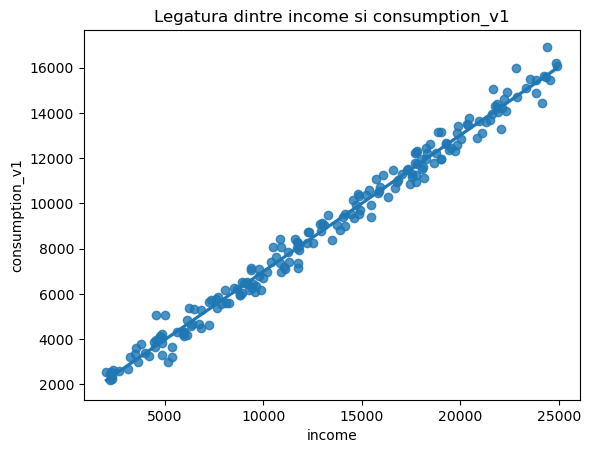

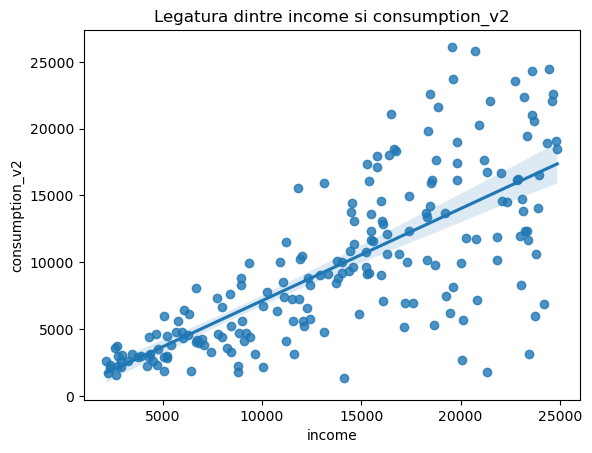

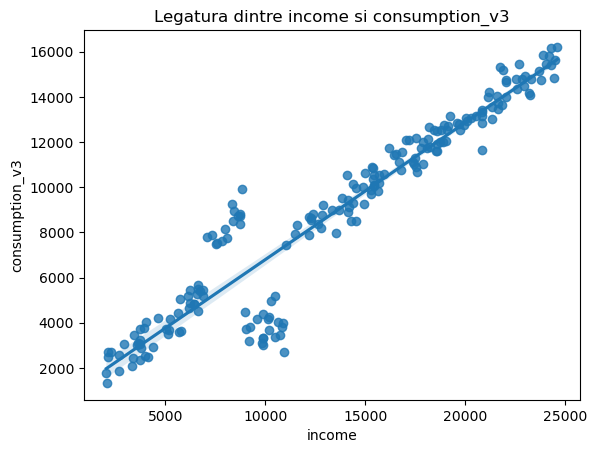

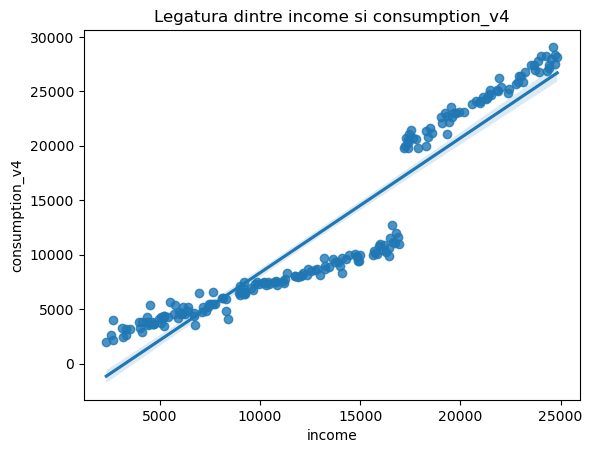

In [245]:

for scenariu in scenarii_simulate_denumiri:
    relationship_plot = sns.regplot(data=df.sample(200), x='income',y=scenariu)
    relationship_plot.set_title(f"Legatura dintre income si {scenariu}")
    plt.show()


### 2. Eroarea conditionata este 0  
### 3. Homoscedasticitatea

In [246]:
#Define the bins and labels
bins = range(2000, 30001, 500)
labels = [f"{i}_{i+500}" for i in range(2000, 30000, 500)]

# Add a new column with the interval labels
df['interval_income'] = pd.cut(df['income'], bins=bins, labels=labels, right=False)

df

,income,consumption_v1,consumption_v2,consumption_v3,consumption_v4,pred_v1,pred_v2,pred_v3,pred_v4,error_v1,error_v2,error_v3,error_v4,interval_income
0,15577.641687,10161.060363,11670.713582,10371.775235,10648.570075,10312.556550,10077.867809,10267.073247,15435.437186,-151.496187,1592.845773,104.701987,-4786.867111,15500_16000
1,23775.593782,15308.070862,8967.215922,15041.317709,27311.507779,15209.561561,14854.432381,15147.165039,25658.737828,98.509301,-5887.216459,-105.847330,1652.769951,23500_24000
2,5190.533163,4832.156284,5321.523376,4179.171461,3796.992555,4107.870073,4025.783823,4083.816445,2482.137141,724.286210,1295.739553,95.355015,1314.855414,5000_5500
3,7567.810865,5211.902441,5754.573838,7049.593804,5363.255808,5527.924824,5410.912734,5498.966628,5446.734198,-316.022383,343.661104,1550.627176,-83.478391,7500_8000
4,16047.066438,11148.338777,9154.636792,11193.383397,10508.414207,10592.965039,10351.379731,10546.513264,16020.835869,555.373738,-1196.742939,646.870133,-5512.421662,16000_16500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,7822.177889,5159.213714,6840.523504,8037.332502,4614.904881,5679.869673,5559.120543,5650.386691,5763.943977,-520.655959,1281.402962,2386.945810,-1149.039096,7500_8000
99996,17681.017928,11808.509510,8533.984475,11345.397556,21803.554226,11568.997655,11303.407105,11519.174871,18058.463940,239.511855,-2769.422630,-173.777315,3745.090286,17500_18000
99997,17110.026820,11998.237329,1763.359719,12151.805232,19602.705770,11227.919020,10970.717201,11179.274249,17346.406382,770.318309,-9207.357482,972.530984,2256.299388,17000_17500
99998,5979.178756,4436.051544,4409.589133,4536.829788,4637.032097,4578.963509,4485.290851,4553.282824,3465.621907,-142.911966,-75.701718,-16.453036,1171.410190,5500_6000


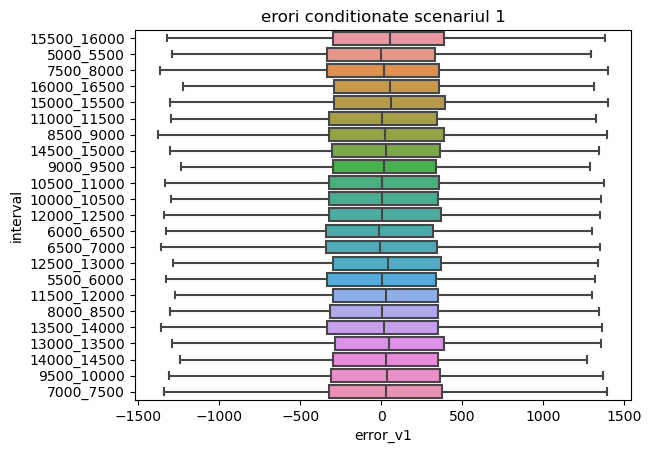

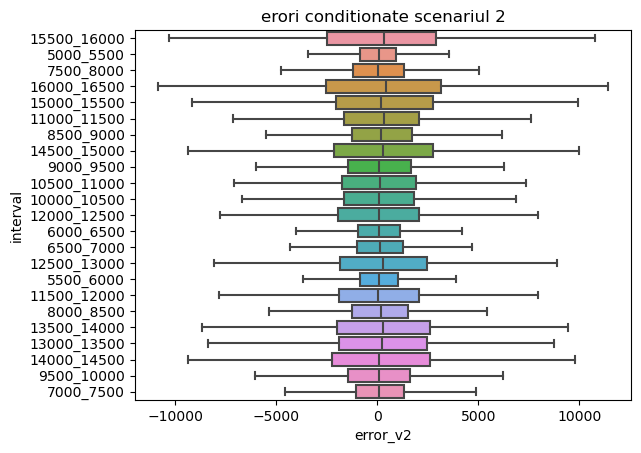

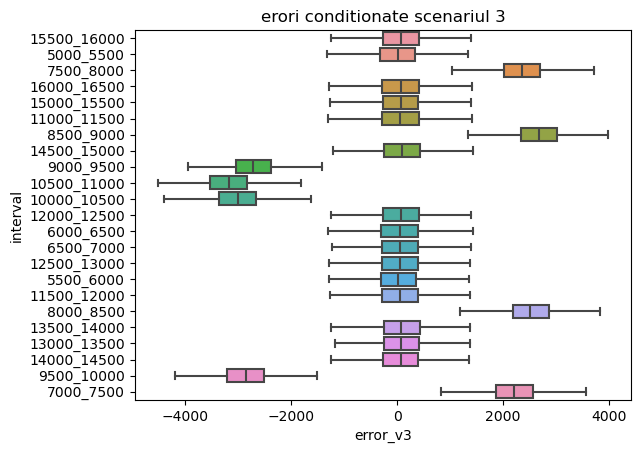

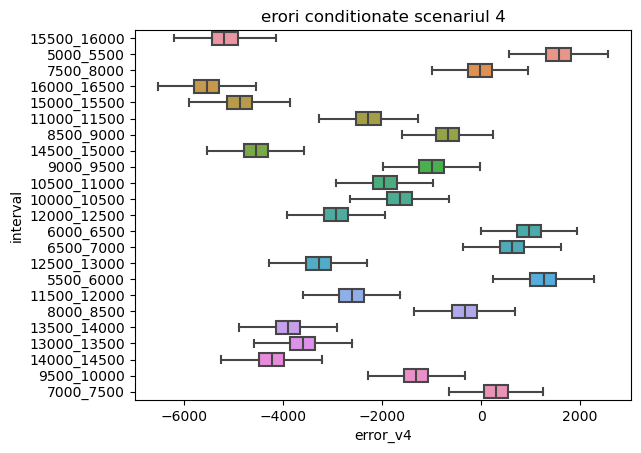

In [247]:
for scenariu in scenarii_simulate_versiuni:
    #definim un doar un subset de intervale x pentru care sa vizualizam
    df_sample2 = df[df['income'].between(5000,16500)].copy() #pot fi schimbate 5000 si 6000 cu alte valori
    df_sample2['interval'] = df_sample2['interval_income'].astype('str')
    erori_conditionat_boxplot = sns.boxplot(data=df_sample2, y='interval',x=f"error_v{scenariu}", showfliers=False)
    erori_conditionat_boxplot.set_title(f"erori conditionate scenariul {scenariu}")
    plt.show()




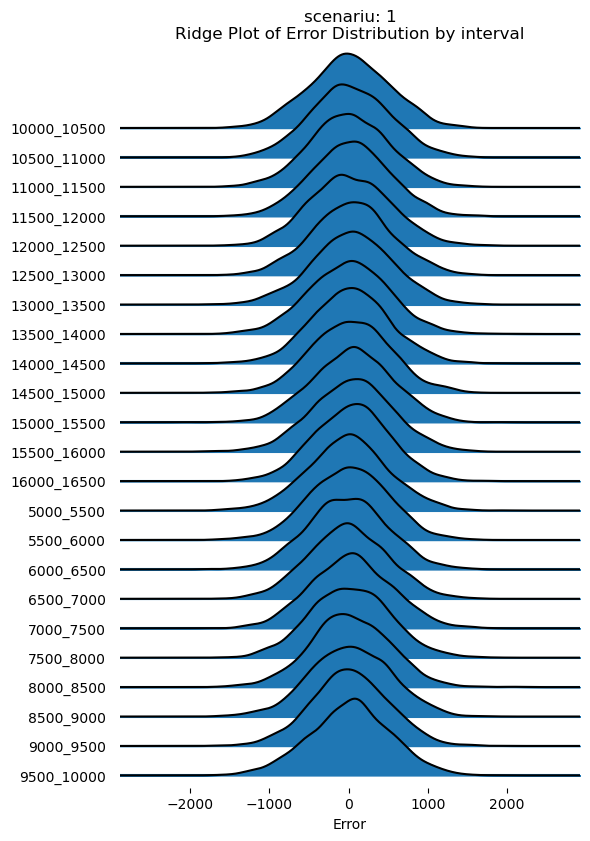

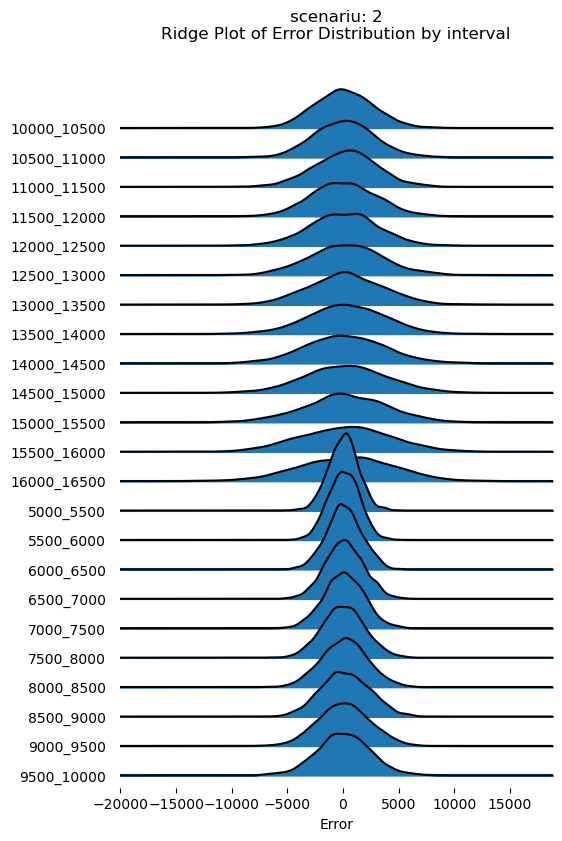

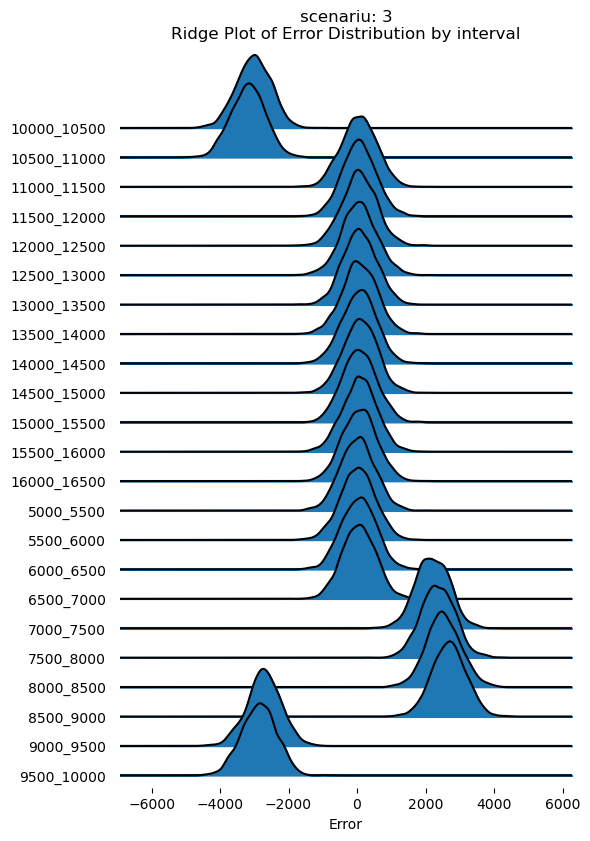

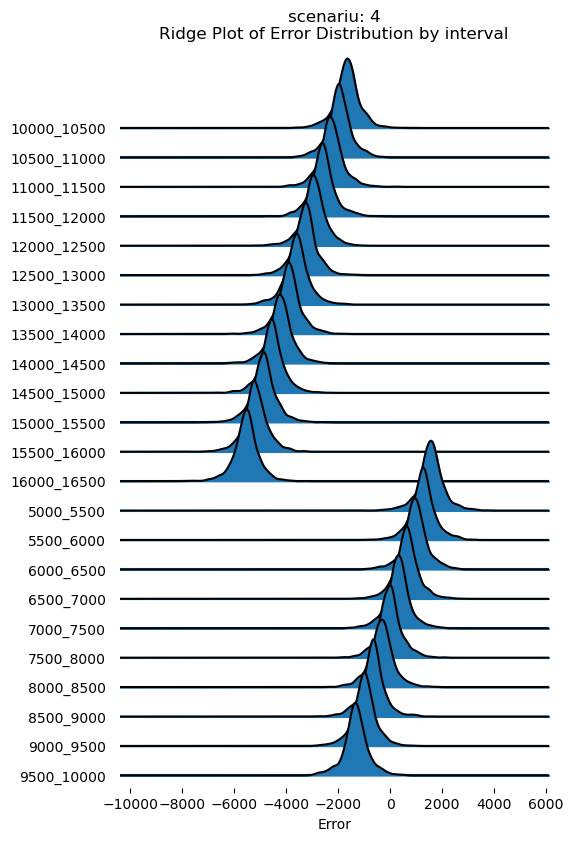

In [248]:
for scenariu in scenarii_simulate_versiuni:

    #Create a ridge plot using joypy
    fig, axes = joypy.joyplot(df_sample2, by="interval", column=f"error_v{scenariu}", figsize=(6, 8))

    # Customize the plot if needed
    plt.title(f"scenariu: {scenariu}\nRidge Plot of Error Distribution by interval")
    plt.xlabel("Error")
    plt.ylabel("Label")
    plt.show()

### 4. Variabile independente necorelate cu erorile

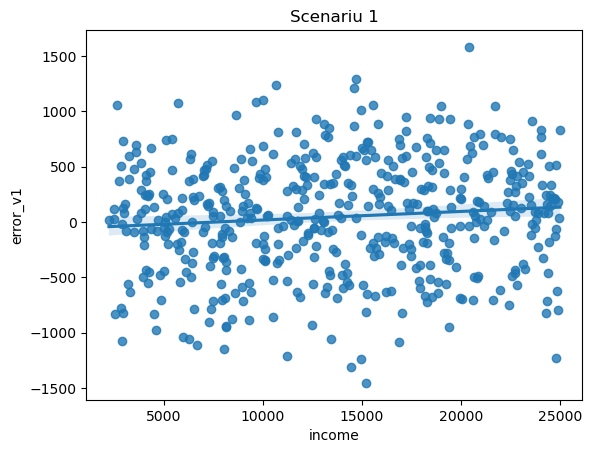

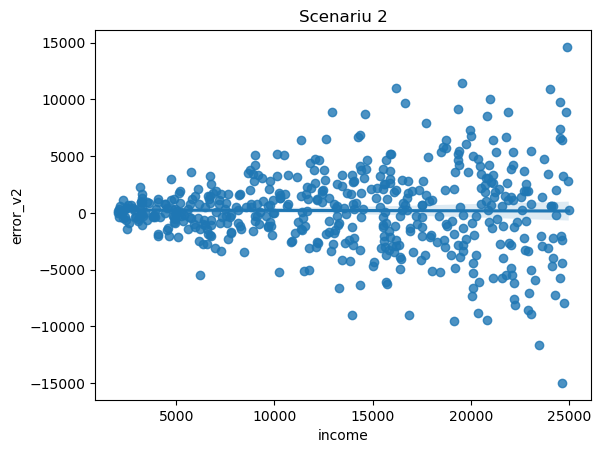

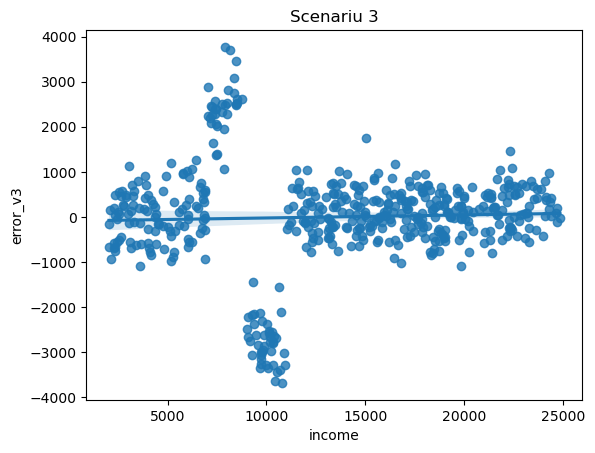

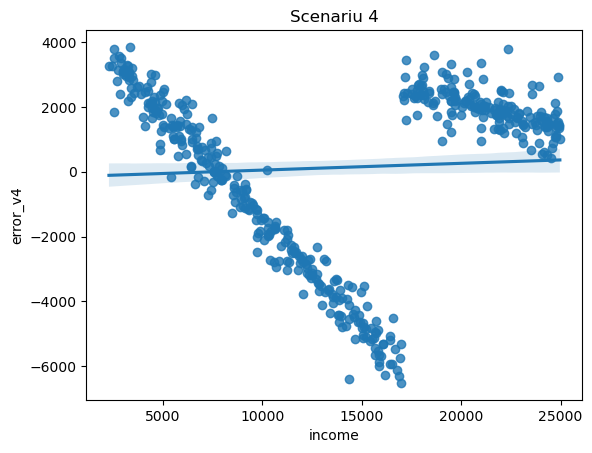

In [249]:
for scenariu in scenarii_simulate_versiuni:
    scatter_plot_errors_x = relationship_plot = sns.regplot(data=df.sample(500), x='income',y=f'error_v{scenariu}')
    scatter_plot_errors_x.set_title(f'Scenariu {scenariu}')
    plt.show()